## Preliminaries

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

dtype = torch.float
device = torch.device("cpu")
#device = torch.device("mps")
#device = torch.device("cuda:0") # Uncomment this to run on GPU
import NeuralNetwork as NN
import Layer
import importlib
import time
from copy import deepcopy
from IPython.display import display
from ipywidgets import FloatProgress

import mnist_loader

%load_ext autoreload
%autoreload 2

def DrawDigit(x):
    plt.imshow(np.reshape(x, (28,28)), cmap='gray', interpolation='nearest')
    plt.axis('off');

## Load MNIST DATA

In [2]:
train, validate, test = mnist_loader.load_data_wrapper('mnist.pkl')
train = [torch.tensor(train[0]).float().to(device), torch.tensor(train[1]).float().to(device)]
test = [torch.tensor(test[0]).float().to(device), torch.tensor(test[1]).float().to(device)]

/var/folders/97/ppgk101x3214hn7bzlb85jk00000gn/T/ipykernel_75026/3892626216.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  train = [torch.tensor(train[0]).float().to(device), torch.tensor(train[1]).float().to(device)]


In [3]:
idx = [1, 3, 25, 7, 58,145, 62, 79, 41, 57]

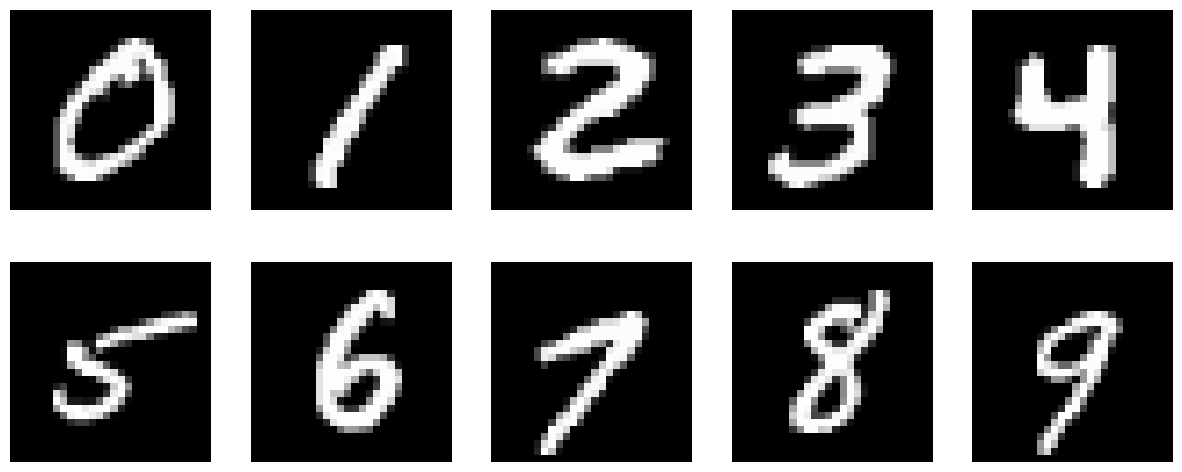

In [4]:
#      0  1   2  3   4   5   6   7   8   9
idx = [1, 3, 25, 7, 58,145, 62, 79, 41, 57]
plt.figure(figsize=[15,6])
for n,k in enumerate(idx):
    plt.subplot(2,5,n+1)
    DrawDigit(train[0][k].cpu())

## Create Network

In [5]:
# Deep Reversed
net = NN.NeuralNetwork()
net.AddLayer(Layer.InputPELayer(n=10))
net.AddLayer(Layer.PELayer(n=600))
net.AddLayer(Layer.PELayer(n=600))
net.AddLayer(Layer.TopPELayer(n=784))

af = 'tanh'
sym = False

net.Connect(0, 1, act=af, symmetric=sym)
net.Connect(1, 2, act=af, symmetric=sym)
net.Connect(2, 3, act=af, symmetric=sym)

net.SetTau(0.08)
net.learn_biases = False

tanh
tanh
tanh


In [7]:
for i in range(0, len(net.connections)):
    W = np.load('generatively_trained_W_{i}.npy'.format(i=i))
    M = np.load('generatively_trained_M_{i}.npy'.format(i=i))
    net.connections[i].W = torch.tensor(W).float().to(device)
    net.connections[i].M = torch.tensor(M).float().to(device)

In [8]:
for c in net.connections:
    print(c.W)
    print(c.M)

tensor([[ 0.0283,  0.0024, -0.0135,  ..., -0.0123, -0.0201, -0.0120],
        [-0.0355,  0.0427,  0.0064,  ..., -0.0229,  0.0411, -0.0167],
        [ 0.0262, -0.0235,  0.0294,  ..., -0.0095, -0.0241,  0.0224],
        ...,
        [ 0.0076,  0.0328,  0.0267,  ...,  0.0256,  0.0448,  0.0106],
        [ 0.0235,  0.0359,  0.0169,  ..., -0.0308, -0.0103, -0.0393],
        [ 0.0021, -0.0047,  0.0377,  ..., -0.0217, -0.0223,  0.0088]])
tensor([[ 0.0283, -0.0355,  0.0262,  ...,  0.0076,  0.0235,  0.0021],
        [ 0.0024,  0.0427, -0.0235,  ...,  0.0328,  0.0359, -0.0047],
        [-0.0135,  0.0064,  0.0294,  ...,  0.0267,  0.0169,  0.0377],
        ...,
        [-0.0123, -0.0229, -0.0095,  ...,  0.0256, -0.0308, -0.0217],
        [-0.0201,  0.0411, -0.0241,  ...,  0.0448, -0.0103, -0.0223],
        [-0.0120, -0.0167,  0.0224,  ...,  0.0106, -0.0393,  0.0088]])
tensor([[ 3.0596e-03,  5.7404e-04,  1.4568e-03,  ..., -1.7131e-03,
         -2.1936e-03, -7.9853e-04],
        [ 2.1024e-03, -2.6317

In [9]:
net1 = deepcopy(net)

In [10]:
# FAST METHOD: Training Accuracy
correct = 0
for i in range(0, 5):
    z = net1.BackprojectExpectation(train[0][i*10000:(i+1)*10000])
    y_classes = np.argmax(z.cpu(),1)
    t_classes = np.argmax(train[1][i*10000:(i+1)*10000].cpu(), 1)
    correct += np.count_nonzero((y_classes - t_classes)==0)
print('train set accuracy: {rate}'.format(rate=(correct / len(train[0]))))

train set accuracy: 0.70378


In [11]:
# FAST METHOD: Test Accuracy
correct = 0
z = net1.BackprojectExpectation(test[0])
#z = net.connections[0].sigma(net.layers[1].v)@net.connections[0].M + net.layers[0].b
y_classes = np.argmax(z.cpu(),1)
t_classes = np.argmax(test[1].cpu(), 1)
correct = np.count_nonzero((y_classes - t_classes)==0)
print('test set accuracy: {rate}'.format(rate=(correct / len(test[0]))))

test set accuracy: 0.7141


Total time: 60.354187965393066


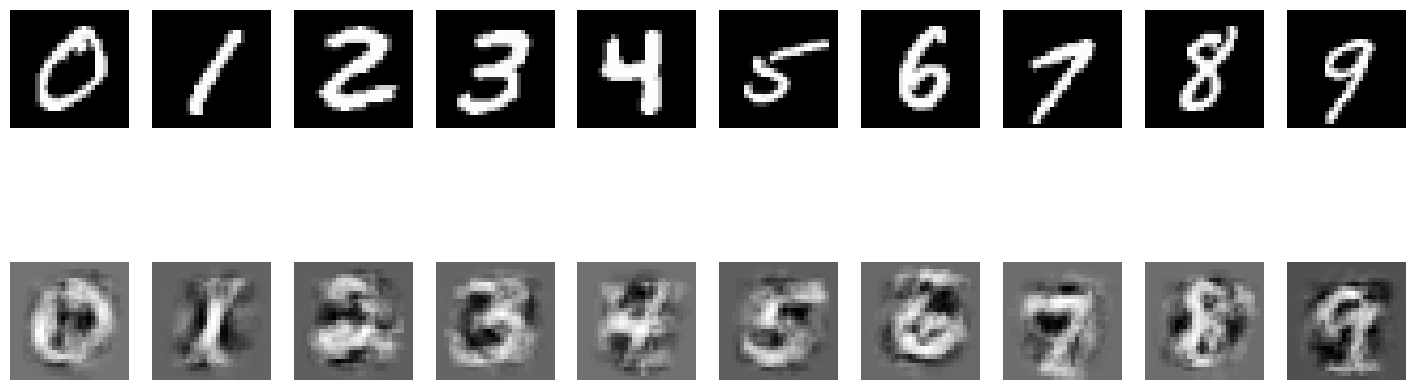

In [12]:
start = time.time()
net1.Reset()
net1.SetvDecay(0.001)
net1.layers[0].SetFF()
net1.layers[-1].SetFF()
z1 = net1.Predict(60., train[1][idx], dt=0.002)
plt.figure(figsize=[18,6])
for n in range(10):
    zz1 = z1[n]
    plt.subplot(2,10,n+1); DrawDigit(train[0][idx[n]].cpu())
    plt.subplot(2,10,n+11); DrawDigit(zz1.cpu())
    
print(f'Total time: {time.time()-start}')